In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch import nn
import numpy.polynomial.chebyshev as cheb

In [2]:
cheb.chebpts2(5)

array([-1.00000000e+00, -7.07106781e-01,  6.12323400e-17,  7.07106781e-01,
        1.00000000e+00])

# Load data and create datasets

In [3]:
batch_size = 512
datastore = h5py.File('trials6.h5', 'r')
data_I = torch.tensor(np.array(datastore["I"]))
data_c = torch.tensor(np.array(datastore["c"]))
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


/var/folders/gc/0752xrm56pnf0r0dsrn5370c0000gr/T/ipykernel_27329/1543618932.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  data_I = torch.tensor(np.array(datastore["I"]))
/var/folders/gc/0752xrm56pnf0r0dsrn5370c0000gr/T/ipykernel_27329/1543618932.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  data_c = torch.tensor(np.array(datastore["c"]))


In [5]:
N = data_I.shape[1]
xc = cheb.chebpts2(N)
Ic = cheb.chebfit(xc, data_I[0].numpy(), 16)
Ic

array([ 0.28521594, -0.27515558,  0.12276795, -0.06841707,  0.04665993,
       -0.03361407,  0.02432562, -0.01898448,  0.01481664, -0.01222998,
        0.00997916, -0.0085742 ,  0.00722219, -0.00639272,  0.00551137,
       -0.00499287,  0.00438069])

In [6]:
np.arcsinh(1 / Ic)

array([ 1.96739913, -2.00197757,  2.79435333, -3.37644829,  3.7585605 ,
       -4.08624017,  4.40952034, -4.65737055,  4.90520652, -5.09704945,
        5.30042806, -5.45216358,  5.62375699, -5.74575323,  5.89409769,
       -5.99289803,  6.1237013 ])

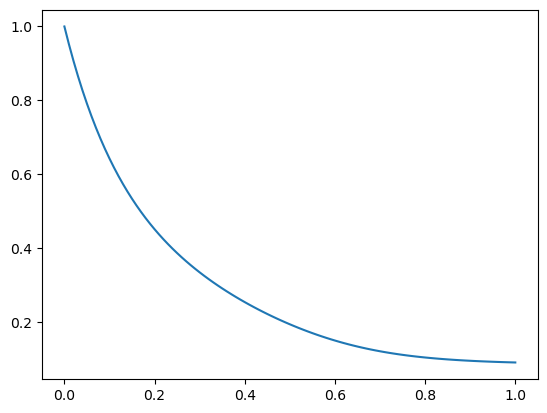

In [10]:
plt.plot(np.array(datastore["t"]), data_I[0])

Input data consists of I values, followed by a t value where c(t) is the output. So we will use every row in `I` combined with the first time value, then every row in `I` combined with the second time value, and so on. There will be (40000)(101) samples now.

In [146]:
class DeepOLoader(Dataset):
    def __init__(self, I, c, device):
        self.times = torch.tensor(np.linspace(0, 1, I.shape[1], dtype=np.float32)).to(device)
        self.intensity = I.to(device)
        self.osmolarity = c.to(device)

    def __len__(self):
        return np.prod(self.intensity.shape)
    
    def reference(self, idx):
        ns, nt = self.intensity.shape
        return idx // ns, idx % ns  # time index, sample index

    def __getitem__(self, idx):
        return self.getitem(idx)
    
    def getitem(self, idx):
        idxt, idxs = self.reference(idx)
        x = torch.cat((self.intensity[idxs, :], self.times[idxt:idxt+1]))
        return x, self.osmolarity[idxs, idxt]

In [147]:
dataset = DeepOLoader(data_I, data_c, device)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [148]:
dataset.reference(40005)

(1, 5)

# Define the model

In [149]:
class Trunk(nn.Module):
    def __init__(self, width):
        super(Trunk, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, width))
        
    def forward(self, x):
        return self.layers(x)

class Branch(nn.Module):
    def __init__(self, width):
        super(Branch, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(101, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, width))
        
    def forward(self, x):
        return self.layers(x)

class DeepO(nn.Module):
    def __init__(self, trunk_width, branch_width):
        super().__init__()
        self.trunk = Trunk(trunk_width)
        self.branch = Branch(branch_width)

    def forward(self, x):
        t = self.trunk(x[:, -1:])
        b = self.branch(x[:, :-1])
        return torch.multiply(t, b).sum(dim=1)

In [150]:
model = DeepO(40, 40).to(device)
print(model)

DeepO(
  (trunk): Trunk(
    (layers): Sequential(
      (0): Linear(in_features=1, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=40, bias=True)
      (3): ReLU()
      (4): Linear(in_features=40, out_features=40, bias=True)
      (5): ReLU()
      (6): Linear(in_features=40, out_features=40, bias=True)
    )
  )
  (branch): Branch(
    (layers): Sequential(
      (0): Linear(in_features=101, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=40, bias=True)
      (3): ReLU()
      (4): Linear(in_features=40, out_features=40, bias=True)
      (5): ReLU()
      (6): Linear(in_features=40, out_features=40, bias=True)
    )
  )
)


## Test model on an input

In [151]:
model( next(iter(train_dataloader))[0] )

tensor([ 1.6765e-02, -1.5092e-03,  5.6778e-03,  2.7395e-02, -6.1011e-05,
         9.8121e-03, -4.6778e-03,  7.2494e-03,  5.6259e-03,  1.0517e-02,
         6.4039e-03,  8.1937e-03, -7.5053e-04,  1.8640e-02,  8.5262e-03,
         7.4270e-03,  1.0852e-02,  5.7265e-03, -8.7660e-04, -4.6327e-03,
         2.4625e-03,  2.3475e-03,  4.6998e-03, -2.9648e-03,  1.6216e-02,
         9.2860e-03,  1.7871e-02,  4.1108e-03,  1.1611e-02,  1.5366e-02,
         3.9910e-03,  1.2161e-02,  4.9646e-03, -6.2888e-03,  9.1449e-03,
         4.4905e-03,  1.3486e-02,  4.7302e-03,  7.7428e-03,  1.3212e-02,
         1.6304e-02,  4.6119e-03,  1.8877e-02,  3.0977e-03,  8.1976e-03,
         5.2986e-03,  4.1021e-03,  4.0498e-04,  4.3534e-05,  1.0410e-03,
         3.5987e-03,  9.7818e-03,  1.5585e-02,  6.8648e-03,  3.2998e-03,
         3.3688e-03,  2.6611e-03,  7.0507e-03,  4.0402e-03,  4.7510e-03,
         7.4023e-03,  2.6320e-03,  2.0160e-02, -1.7770e-03, -1.5062e-03,
        -4.5610e-03, -6.1367e-04,  2.6712e-03,  5.5

# Training

In [152]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: Avg loss = {test_loss:>8f} \n")

In [153]:
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 16.806425  [  512/3232000]
loss: 2.300101  [51712/3232000]
loss: 1.705386  [102912/3232000]
loss: 1.738791  [154112/3232000]
loss: 1.390396  [205312/3232000]
loss: 1.133089  [256512/3232000]
loss: 1.117069  [307712/3232000]
loss: 0.786019  [358912/3232000]
loss: 0.624501  [410112/3232000]
loss: 0.676129  [461312/3232000]
loss: 0.465115  [512512/3232000]
loss: 0.389291  [563712/3232000]
loss: 0.303545  [614912/3232000]
loss: 0.365946  [666112/3232000]
loss: 0.271775  [717312/3232000]
loss: 0.280524  [768512/3232000]
loss: 0.228337  [819712/3232000]
loss: 0.296486  [870912/3232000]
loss: 0.250653  [922112/3232000]
loss: 0.152643  [973312/3232000]
loss: 0.204580  [1024512/3232000]
loss: 0.189981  [1075712/3232000]
loss: 0.153542  [1126912/3232000]
loss: 0.217246  [1178112/3232000]
loss: 0.195456  [1229312/3232000]
loss: 0.237773  [1280512/3232000]
loss: 0.125869  [1331712/3232000]
loss: 0.125706  [1382912/3232000]
loss: 0.133321  [1434112/3232

# Inspecting results

In [171]:
X, y = next(iter(test_dataloader))
model( X[0:1, :] ), y[0]

(tensor([7.4162], device='mps:0', grad_fn=<SumBackward1>),
 tensor(7.4976, device='mps:0'))

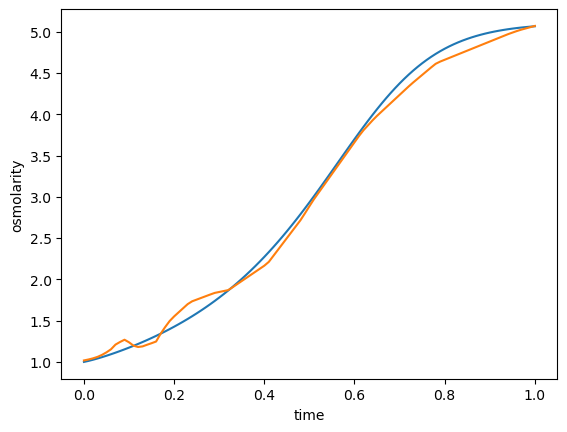

In [177]:
samp = 11111
t = np.linspace(0, 1, 101, dtype=np.float32)
with torch.no_grad():
    pred = [model(torch.cat((data_I[samp:samp+1], torch.tensor(t).reshape(-1, 1)), dim=1).to(device)).cpu().numpy() for t in t]

plt.plot(np.linspace(0, 1, 101), data_c[samp].cpu().numpy(), label="exact")
plt.plot(t, pred, label="predicted")
plt.xlabel("time")
plt.ylabel("osmolarity")
plt.show()